In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from rbf_layer import RBFLayer, l_norm, rbf_gaussian
import traintest as tt
from plot_utils import *
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
from sklearn import mixture, preprocessing, datasets
from copy import deepcopy
%load_ext skip_kernel_extension
%load_ext autoreload
%autoreload 2

In [2]:
# Generate dataset
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

df = pd.DataFrame(data, columns=['feature_1', 'feature_2'])
df=(df-df.min())/(df.max()-df.min()) # normalize [0,1]
df['labels'] = labels
data = torch.tensor(df[['feature_1', 'feature_2']].to_numpy(), dtype=torch.float) 
device=torch.device('cuda:0')

label = torch.tensor(labels, dtype=torch.int64)
train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

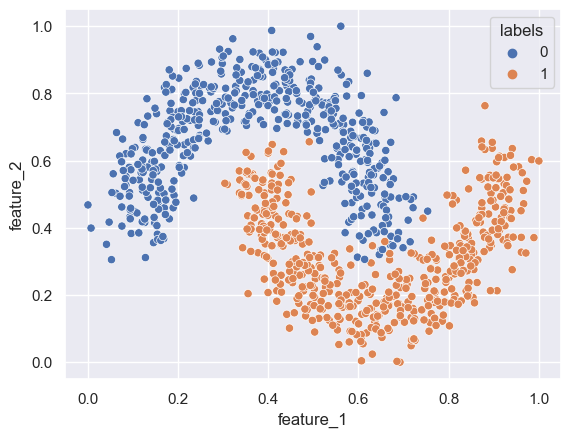

In [3]:
sns.set_theme()
def moons_scatter(df = None,
                  ax=None):
    if ax:
        sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels, ax=ax)
    else:
        sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels)
moons_scatter(df)

In [22]:
# Define an RBF layer where the dimensionality of the input feature is 2,
# the number of kernels is 3, and 2 output features

# euclidean norm
def euclidean_norm(x, p=2, dim=-1):
    return torch.norm(x, p=p, dim=dim)


# Gaussian RBF
def rbf_gaussian(x):
    return (-x.pow(2)).exp()


class TwoMoonsRBFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rbf = RBFLayer(in_features_dim=2,
                               num_kernels=10,
                               out_features_dim=10,
                               radial_function=rbf_gaussian,
                               norm_function=euclidean_norm,
                               normalization=True)
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.rbf(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [23]:
lr = 0.1
decay = 5e-4

RBFnet = TwoMoonsRBFNet()
param_groups = [{'params':RBFnet.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)
rbf_tracker = [deepcopy(RBFnet.rbf)]
for epoch in range(100):
    loss,acc,_ = tt.train_plain(RBFnet.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1)
    rbf_tracker.append(deepcopy(RBFnet.rbf)) # track each step to watch kernels in animation
    if acc > .98:
        print('Done training at EPOCH:',epoch)
        break

Done training at EPOCH: 30


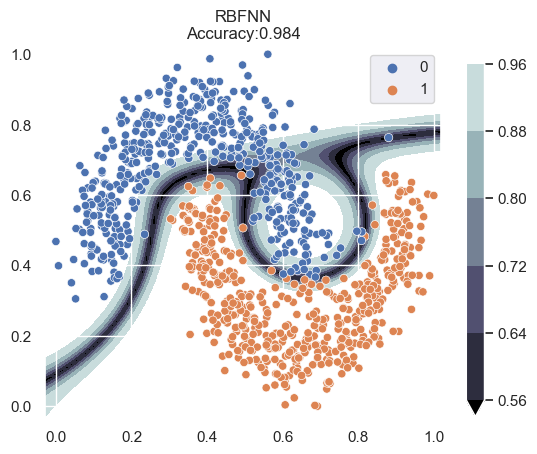

In [24]:
plot_conf(RBFnet, data, label, device=device, title='RBFNN',)

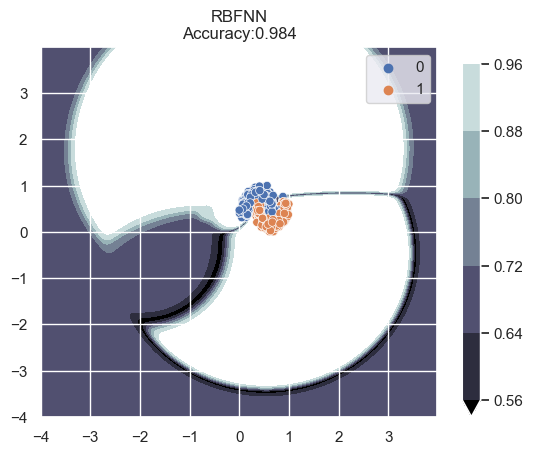

In [25]:
plot_conf(RBFnet, data, label, device=device, title='RBFNN',
         domain = [-4,4])

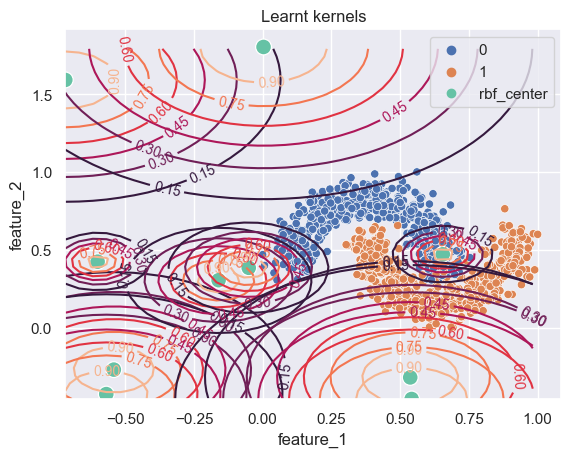

In [26]:
kernel_map(RBFnet.rbf, df)

## Want To Regularize RBFnet to maintain a tighter fit

### Method 1: regularize based on Radial "Volume"

In [29]:
RBFnet.rbf.get_shapes.sum()

tensor(31.4798, device='cuda:0')

In [32]:
(RBFnet.rbf.log_shapes.exp()**2).sum()

tensor(175.5150, device='cuda:0', grad_fn=<SumBackward0>)

In [33]:
np.log(10)

2.302585092994046

In [34]:
np.log(100)

4.605170185988092

In [27]:
1e-8

1e-08

In [58]:
def train_rbf_vol(model, device, train_loader, optimizer, epoch,
                  verbose=100,
                  alpha = 1e-5):


    criterion = nn.NLLLoss()
    model.train()

    train_loss = 0
    correct = 0


    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)

        loss = criterion(output, target) - alpha* (model.rbf.log_shapes.exp()**2).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
    if verbose > 0:
        print(f'Train Epoch: {epoch} [{correct}/{1000} ({correct / 10:.0f}%)]\tLoss: {train_loss:.6f}')
    return train_loss / len(train_loader.dataset), correct / len(train_loader.dataset), 0.

In [34]:
tmp = data[:10]


In [35]:
RBFnet.rbf(tmp.to(device))

tensor([[-0.0502, -0.0126,  0.7135, -0.0211, -0.0954,  0.0140, -0.0050,  1.1277,
         -0.0558, -0.0496],
        [-0.0162, -0.0181,  0.6703, -0.0267,  0.0204,  0.0179, -0.0261,  1.0624,
          0.0267,  0.0261],
        [ 0.0633, -0.0318,  0.5280, -0.0627,  0.2860, -0.0171, -0.0332,  0.6096,
          0.3583,  0.2498],
        [ 0.0453, -0.0130,  0.5306, -0.0247,  0.1356,  0.0166,  0.0262,  0.7737,
          0.1008,  0.0841],
        [ 0.5149, -0.0549, -0.3488, -0.0642,  1.4859,  0.0469, -0.0480, -0.6911,
          1.0293,  0.9349],
        [ 0.4964, -0.0535, -0.3126, -0.0639,  1.4372,  0.0446, -0.0471, -0.6347,
          1.0009,  0.9059],
        [ 0.4612, -0.0487, -0.2502, -0.0599,  1.3315,  0.0426, -0.0369, -0.5288,
          0.9246,  0.8356],
        [ 0.4713, -0.0488, -0.2538, -0.0656,  1.3825,  0.0405, -0.0468, -0.5338,
          0.9743,  0.8680],
        [-0.1552, -0.0106,  0.9348, -0.0162, -0.3683,  0.0108, -0.0215,  1.5112,
         -0.2403, -0.2107],
        [ 0.5185, -

In [41]:
alphas = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8] 

0
1
2
3
4
5


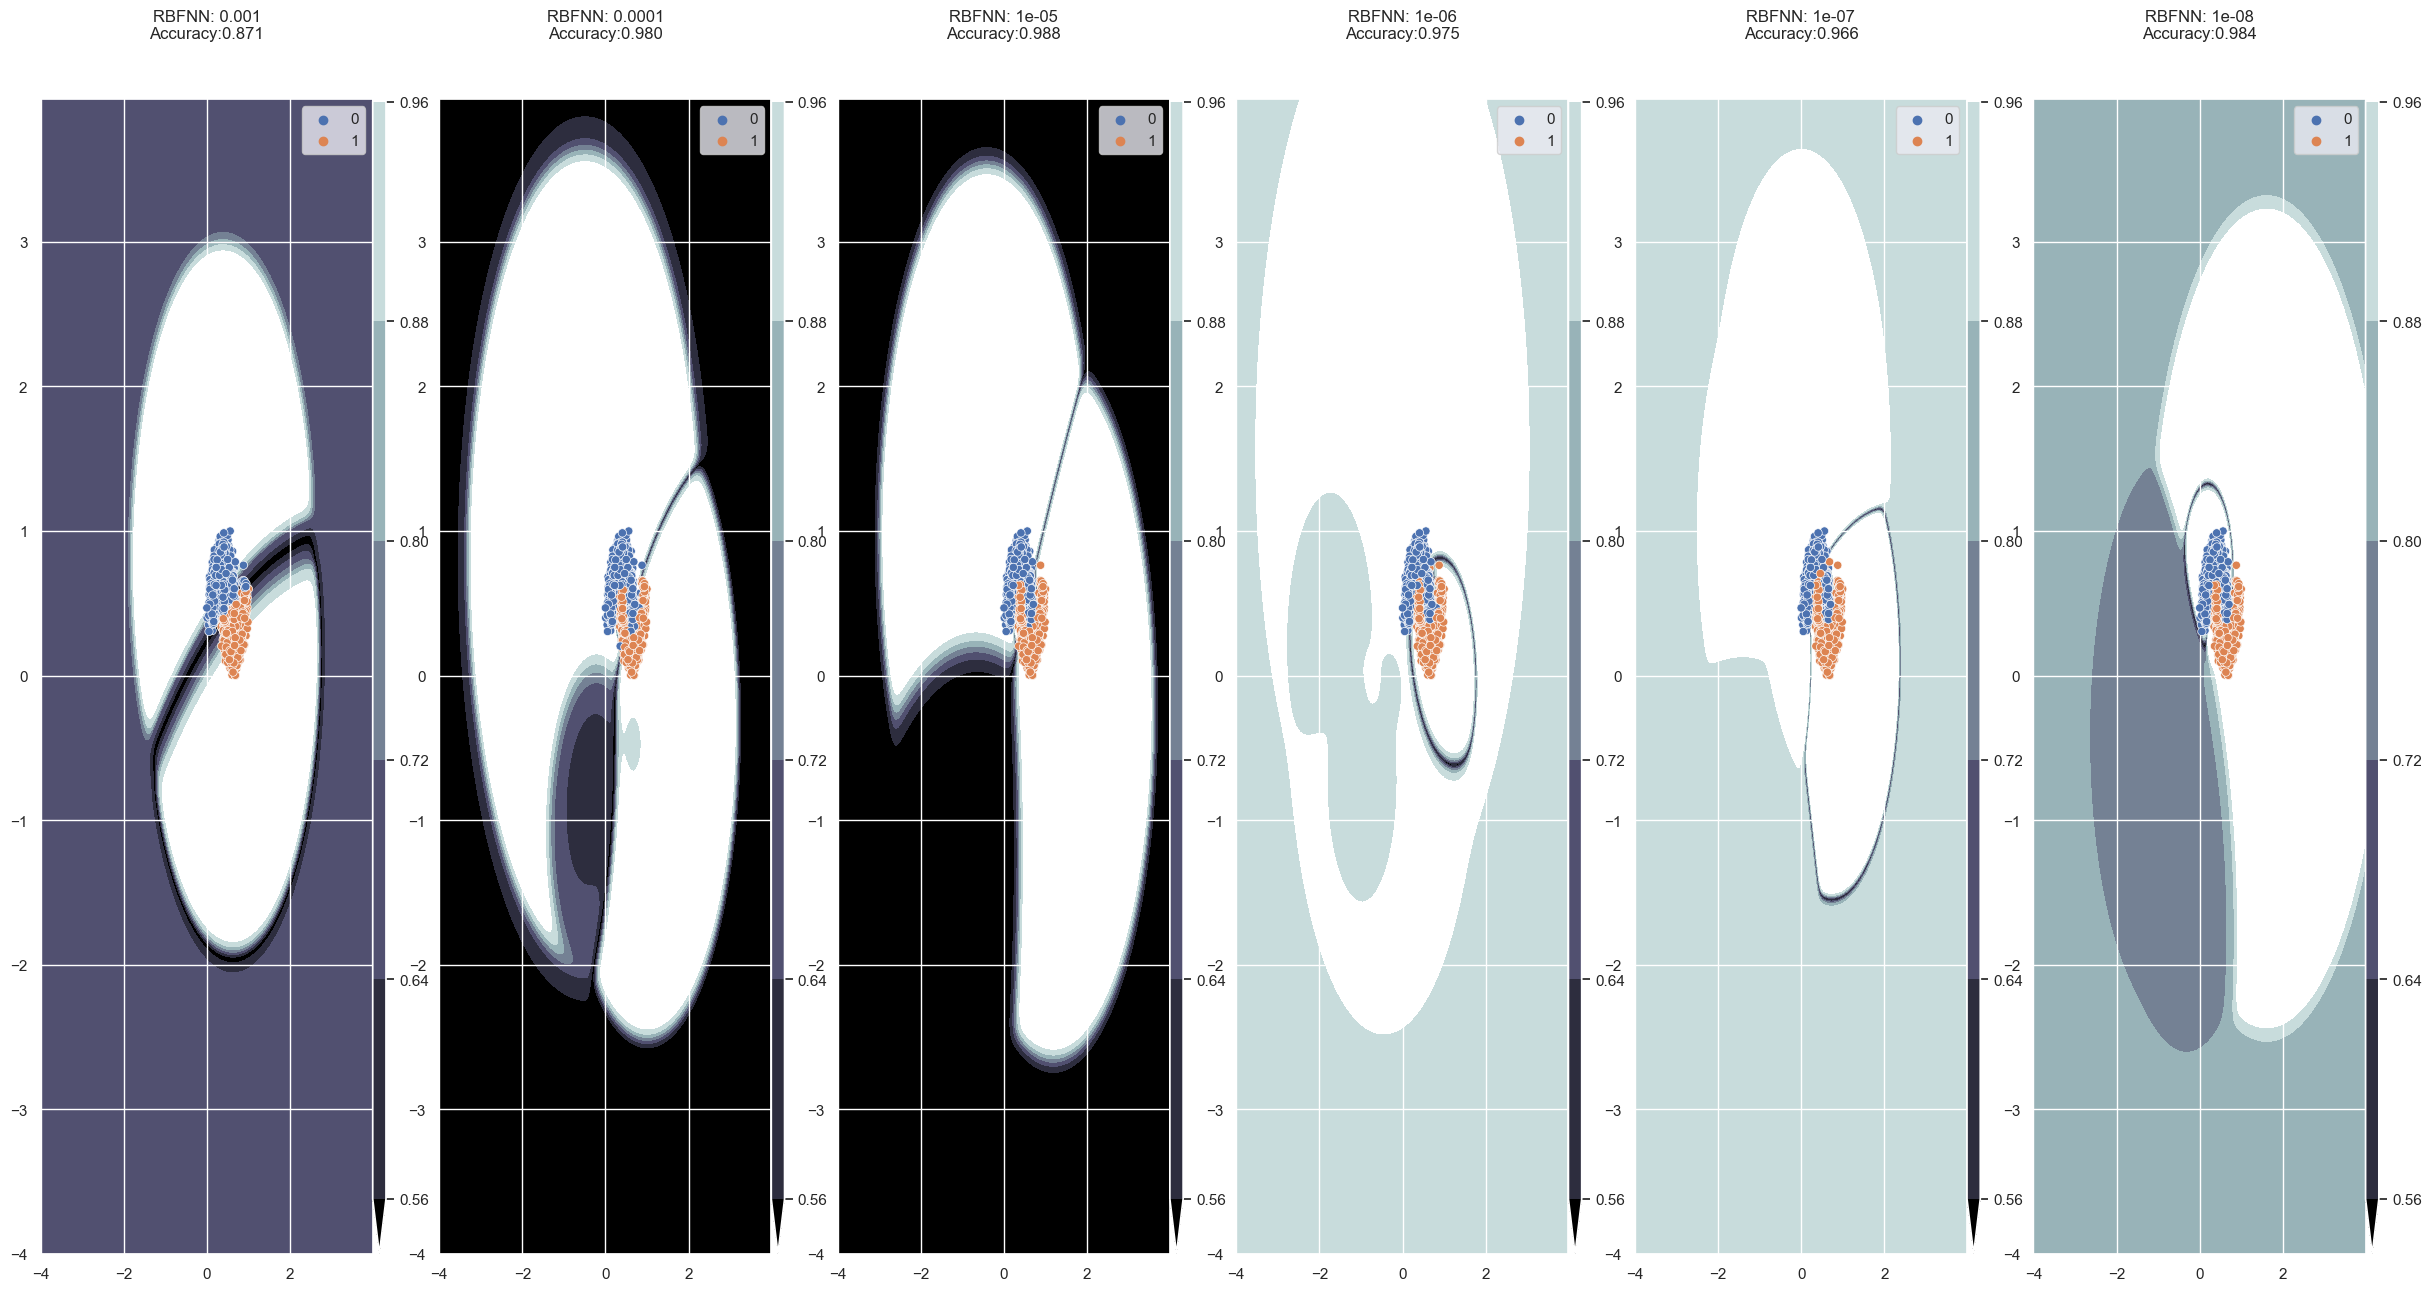

In [57]:
lr = 0.1
decay = 5e-4
fig, axs = plt.subplots(1,6, figsize = (30,15))
for alpha in range(len(alphas)):
    RBFnet = TwoMoonsRBFNet()
    param_groups = [{'params':RBFnet.parameters(),'lr':lr, 'weight_decay':decay}]

    optimizer = optim.Adam(param_groups)
    #rbf_tracker = [deepcopy(RBFnet.rbf)]
    print(alpha)
    for epoch in range(1000):
        
        loss,acc,_ = train_rbf_vol(RBFnet.to(device), device, train_loader, optimizer, 
                        epoch, verbose=0, alpha=alphas[alpha])
        #rbf_tracker.append(deepcopy(RBFnet.rbf)) # track each step to watch kernels in animation
        # if acc > .98:
        #     print('Done training at EPOCH:',epoch)
        #     break
    #plot_conf(RBFnet, data, label, device=device, title=f'RBFNN: {alphas[alpha]}', ax = axs[alpha])
    plot_conf(RBFnet, data, label, device=device, title=f'RBFNN: {alphas[alpha]}', ax = axs[alpha],
             domain = [-4,4])

0
1
2
3
4
5


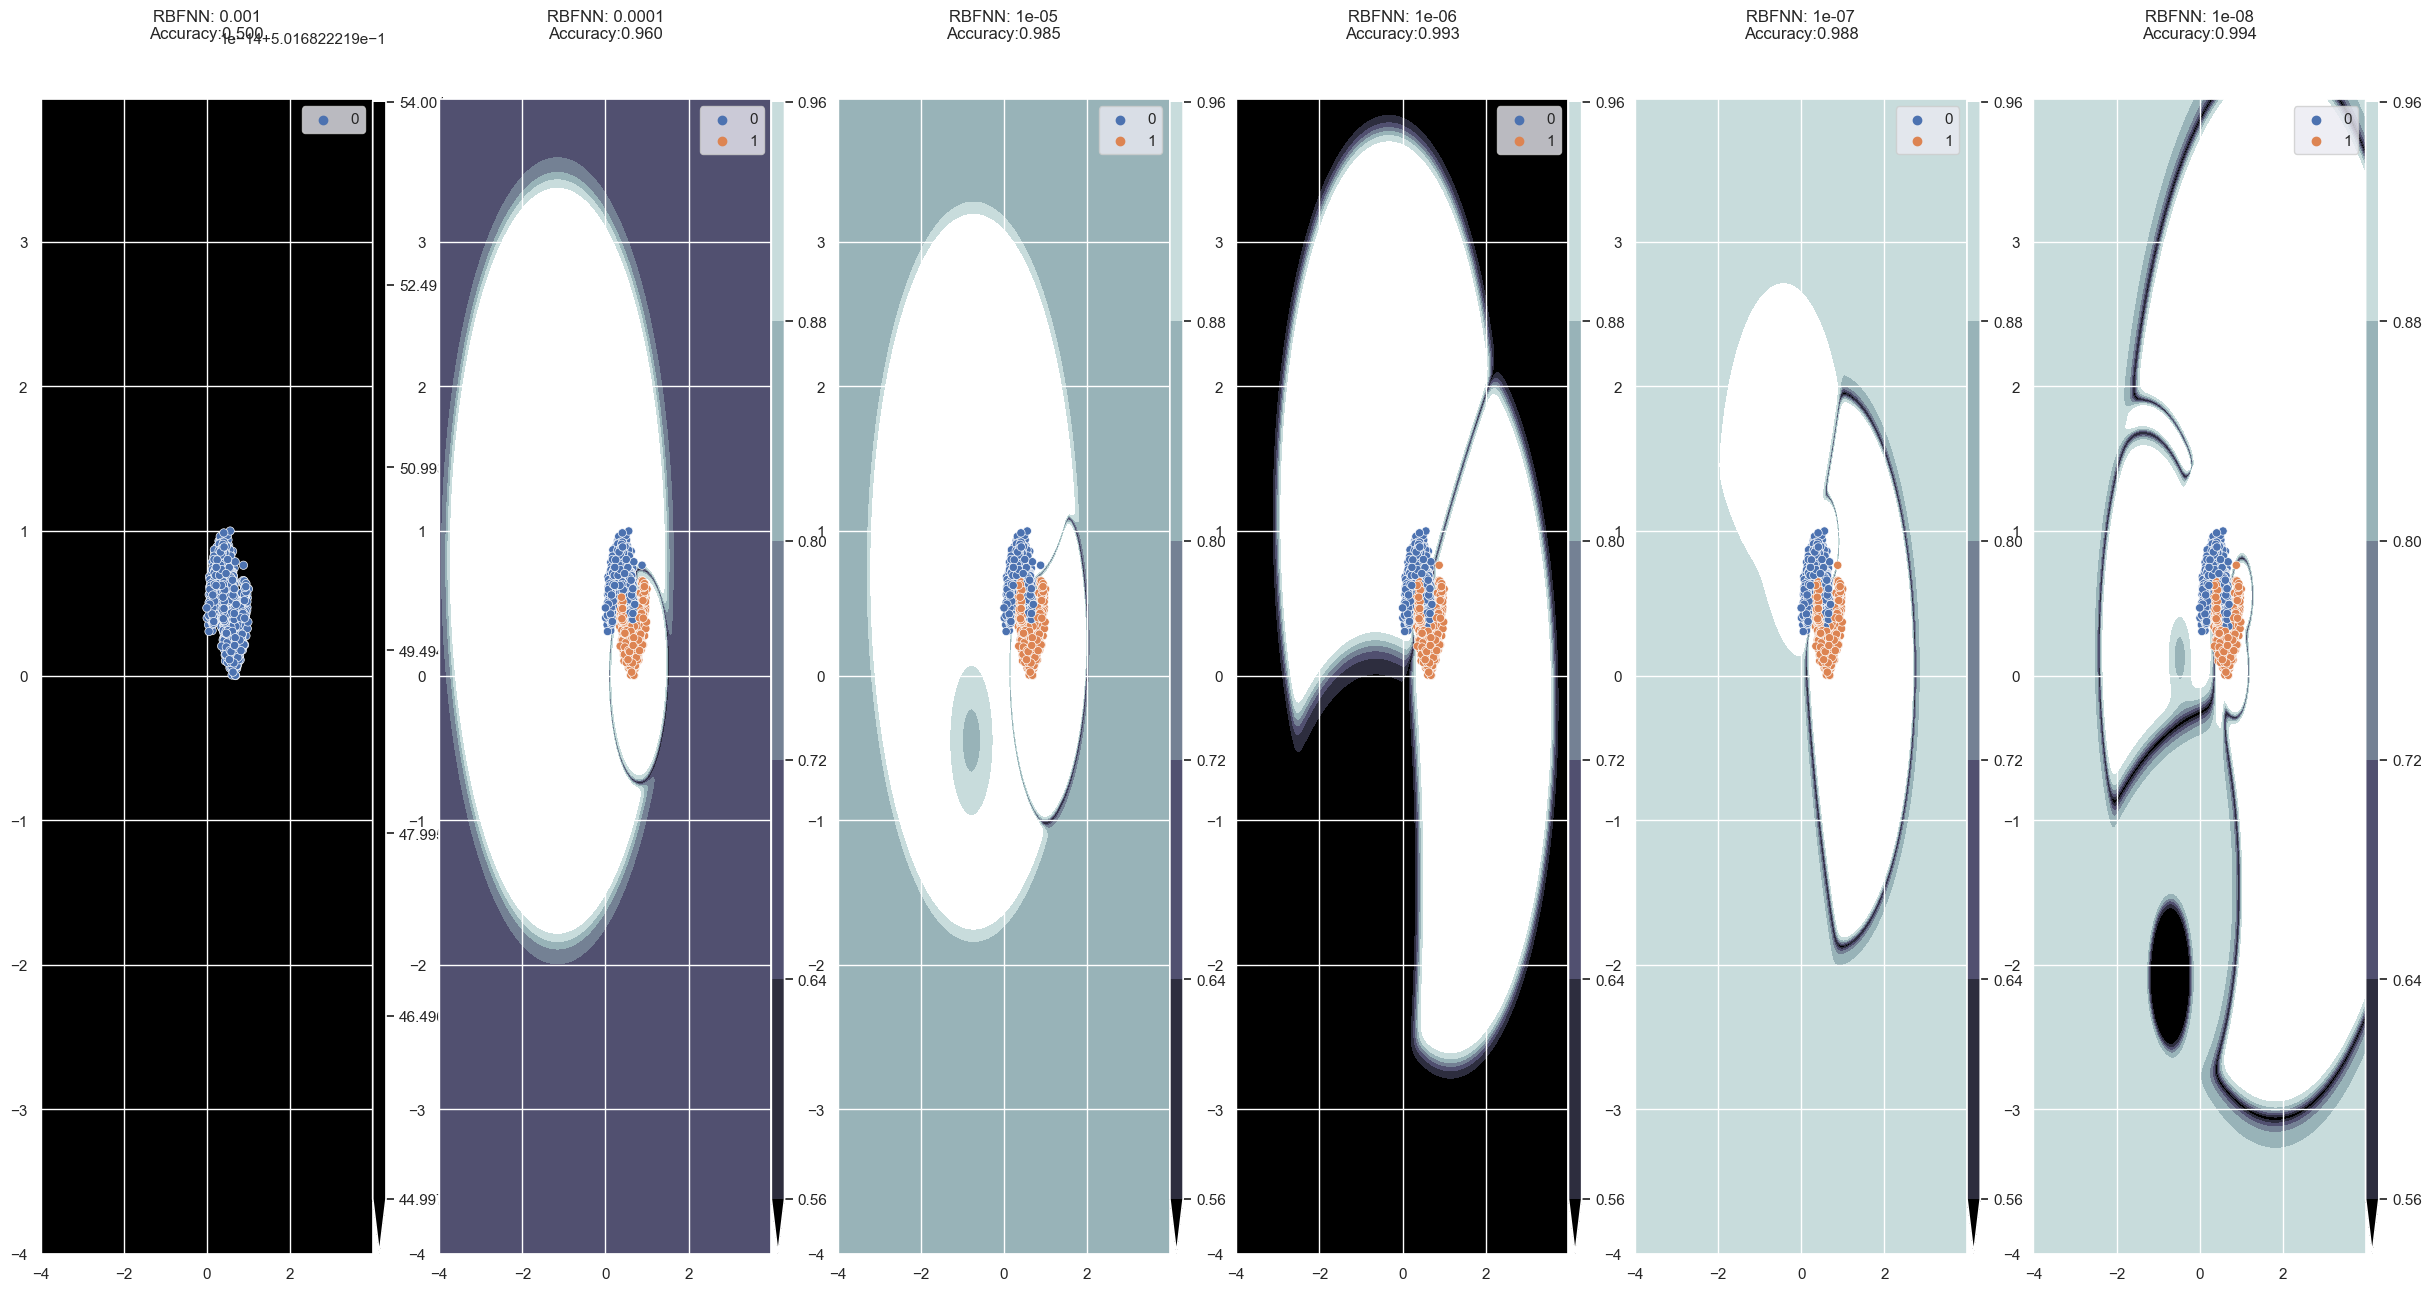

In [60]:
lr = 0.1
decay = 5e-4
fig, axs = plt.subplots(1,6, figsize = (30,15))
for alpha in range(len(alphas)):
    RBFnet = TwoMoonsRBFNet()
    param_groups = [{'params':RBFnet.parameters(),'lr':lr, 'weight_decay':decay}]

    optimizer = optim.Adam(param_groups)
    #rbf_tracker = [deepcopy(RBFnet.rbf)]
    print(alpha)
    for epoch in range(1000):
        
        loss,acc,_ = train_rbf_vol(RBFnet.to(device), device, train_loader, optimizer, 
                        epoch, verbose=0, alpha=alphas[alpha])
        #rbf_tracker.append(deepcopy(RBFnet.rbf)) # track each step to watch kernels in animation
        # if acc > .98:
        #     print('Done training at EPOCH:',epoch)
        #     break
    #plot_conf(RBFnet, data, label, device=device, title=f'RBFNN: {alphas[alpha]}', ax = axs[alpha])
    plot_conf(RBFnet, data, label, device=device, title=f'RBFNN: {alphas[alpha]}', ax = axs[alpha],
             domain = [-4,4])

0
1
2
3
4
5


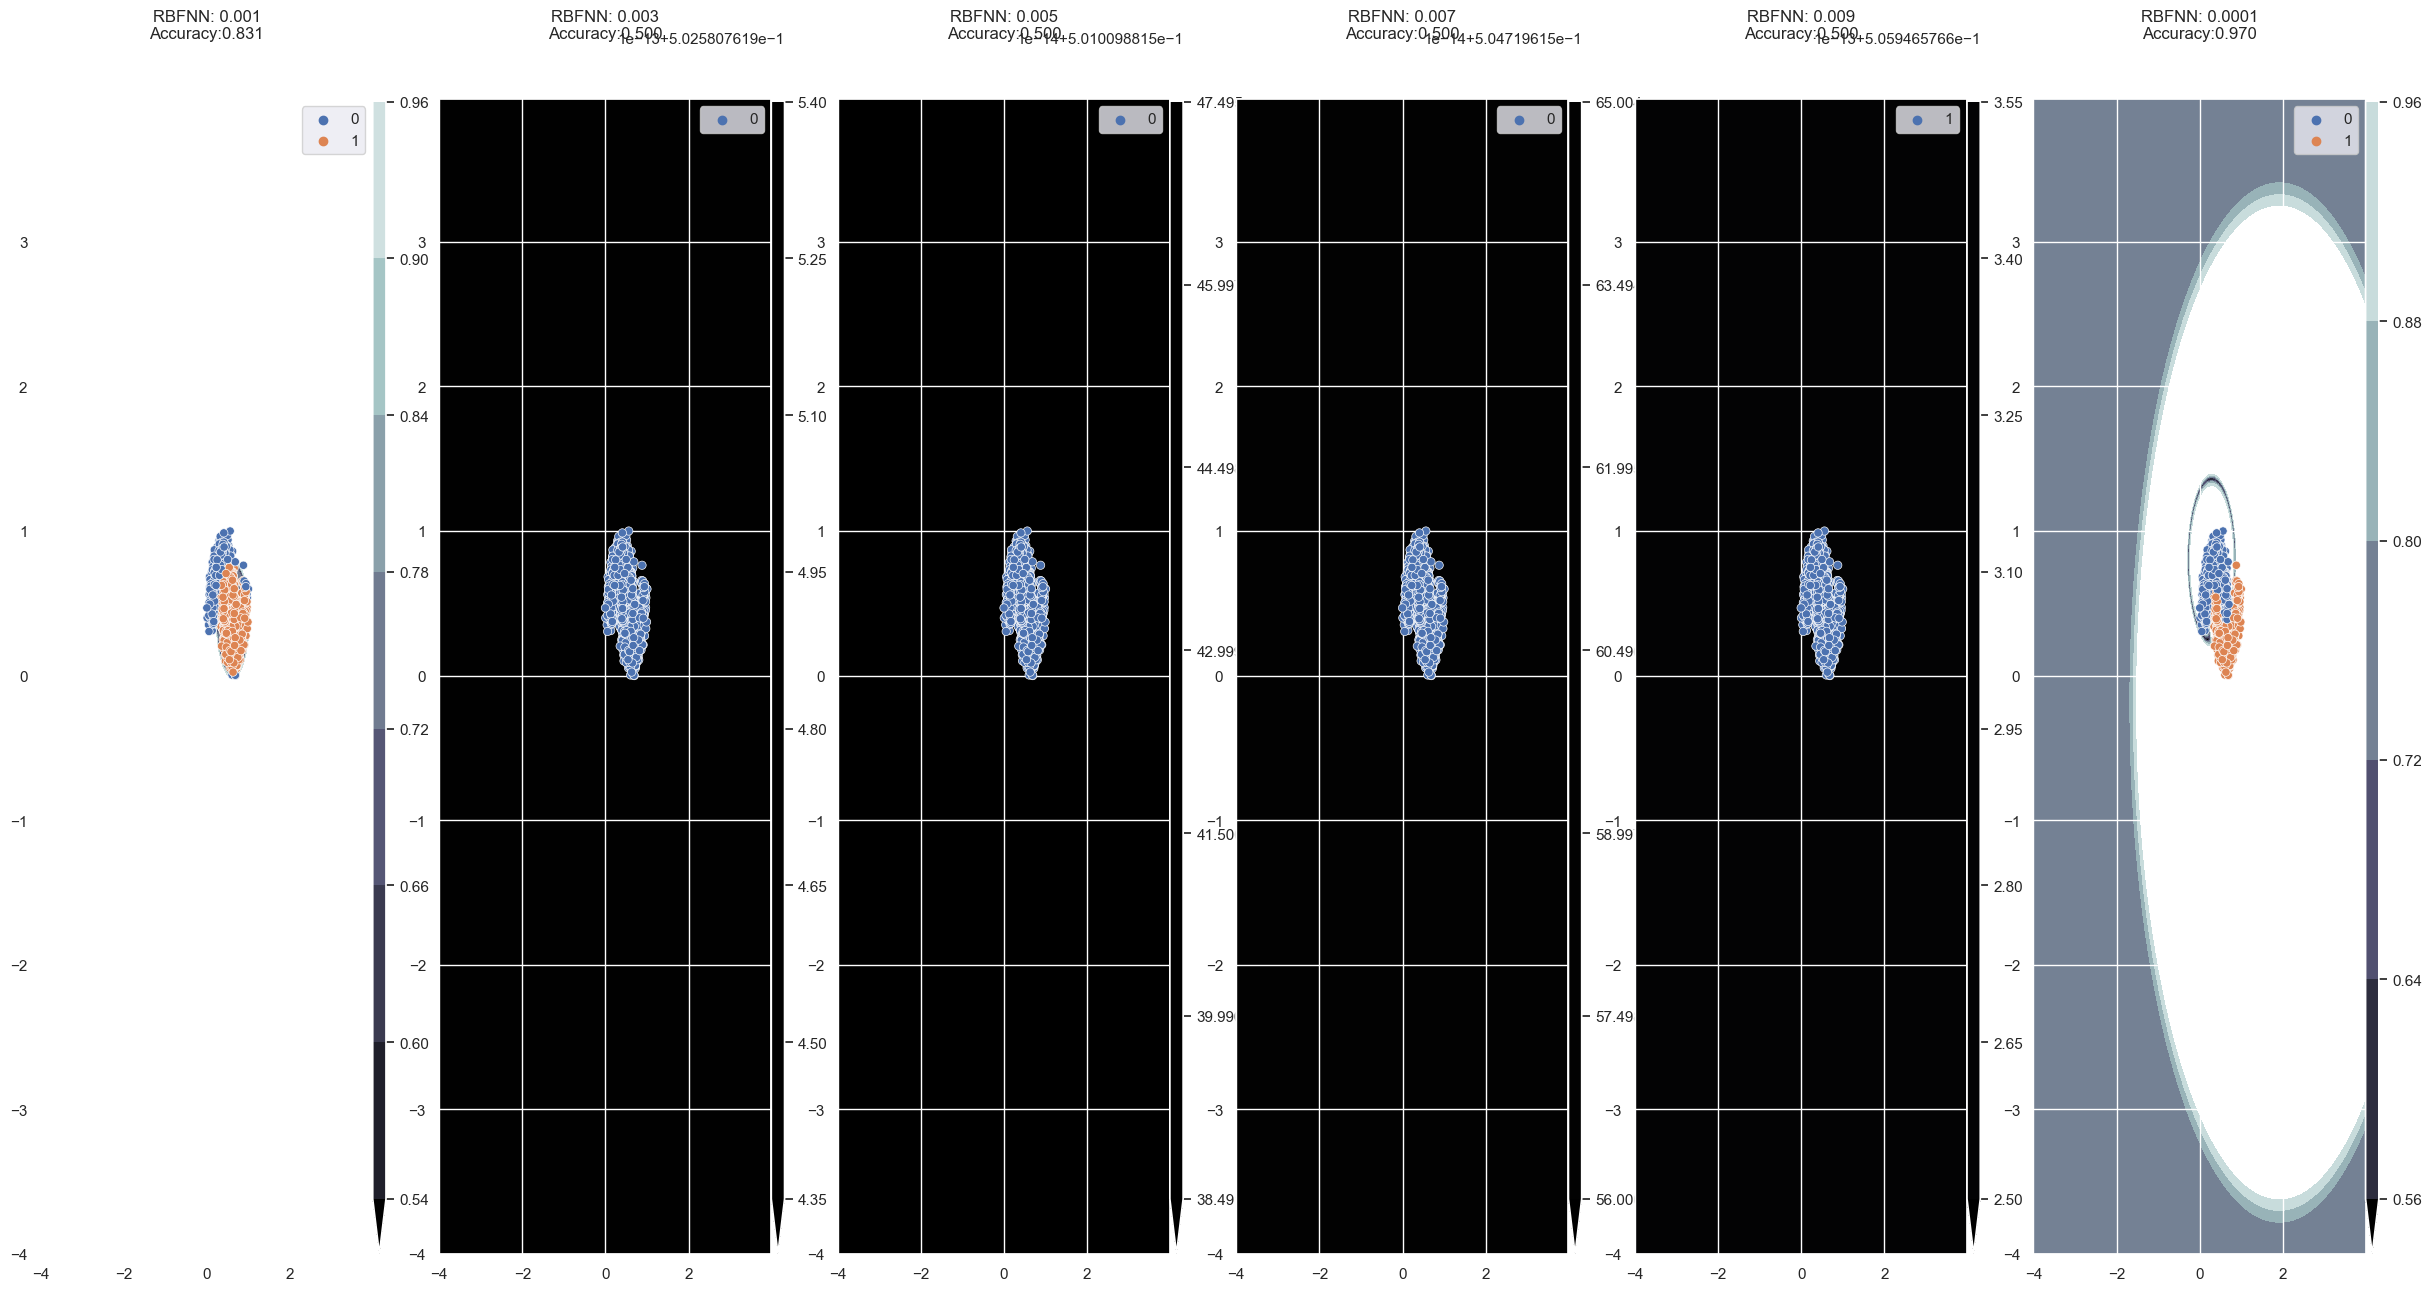

In [61]:
alphas = [1e-3, 3e-3, 5e-3, 7e-3, 9e-3, 1e-4] 

lr = 0.1
decay = 5e-4
fig, axs = plt.subplots(1,len(alphas), figsize = (30,15))
for alpha in range(len(alphas)):
    RBFnet = TwoMoonsRBFNet()
    param_groups = [{'params':RBFnet.parameters(),'lr':lr, 'weight_decay':decay}]

    optimizer = optim.Adam(param_groups)
    #rbf_tracker = [deepcopy(RBFnet.rbf)]
    print(alpha)
    for epoch in range(1000):
        
        loss,acc,_ = train_rbf_vol(RBFnet.to(device), device, train_loader, optimizer, 
                        epoch, verbose=0, alpha=alphas[alpha])
        #rbf_tracker.append(deepcopy(RBFnet.rbf)) # track each step to watch kernels in animation
        # if acc > .98:
        #     print('Done training at EPOCH:',epoch)
        #     break
    #plot_conf(RBFnet, data, label, device=device, title=f'RBFNN: {alphas[alpha]}', ax = axs[alpha])
    plot_conf(RBFnet, data, label, device=device, title=f'RBFNN: {alphas[alpha]}', ax = axs[alpha],
             domain = [-4,4])

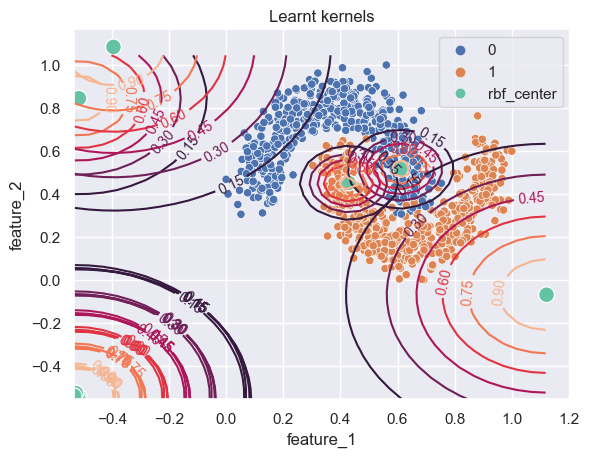

In [39]:
kernel_map(RBFnet.rbf, df)

In [14]:
RBFnet.rbf.get_shapes

tensor([1.8665e+20, 2.1636e+20, 2.0978e+20, 2.1587e+20, 1.9813e+20, 2.2768e+20,
        2.2594e+20, 1.8571e+20, 2.3220e+20, 1.9532e+20], device='cuda:0')

In [15]:
RBFnet.rbf.get_kernels_centers

tensor([[-1.0279e-41, -2.1401e-41],
        [ 8.6390e-42, -7.1929e-42],
        [ 1.7120e-03,  5.1498e-05],
        [-2.1040e-41,  2.2763e-41],
        [ 1.7052e-03, -1.1590e-03],
        [ 1.8386e-41, -3.8897e-41],
        [-5.8014e-43,  1.4115e-41],
        [-2.2795e-38,  5.0405e-07],
        [-1.2021e-07,  5.7733e-42],
        [ 4.1952e-41,  1.8996e-41]], device='cuda:0')

In [16]:
RBFnet.rbf.get_weights.shape

torch.Size([10, 10])